### Standard LSTM - Exp 9
With 7 time steps (For daily forecasting to capture weekly patterns)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular

/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable eager execution
tf.compat.v1.enable_eager_execution()

In [3]:
# Load your preprocessed data (replace 'your_preprocessed_data.csv' with your file path)
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

In [4]:
# Define features and target variable
FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
            'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
            'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
            'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
            'active_power_rolling_mean', 'active_power_rolling_std']

TARGET = 'active_power'

In [5]:
# Extract feature and target values
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)  # Reshape for scaler and LSTM

In [6]:
# Apply MinMax Scaling
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [7]:
# Define time steps for LSTM input
time_steps = 7
features = X_scaled.shape[1]

In [8]:
# Prepare sequential data for LSTM
X_seq = np.array([X_scaled[i-time_steps:i] for i in range(time_steps, len(X_scaled))])
y_seq = y_scaled[time_steps:]

In [9]:
# Split into train-validation-test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Define LSTM Model (Manual Architecture Without Hyperparameter Tuning)
model_lstm = Sequential([
    Input(shape=(time_steps, features)),  # Input layer
    LSTM(128, activation='relu', return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Regularization
    LSTM(64, activation='relu'),  # Second LSTM layer
    Dropout(0.2),  
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1, activation='linear')  # Output layer
])

In [11]:
# Compile model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

In [12]:
# Early stopping and learning rate adjustment
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

In [13]:
# Train the model
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                         callbacks=[early_stop, reduce_lr], verbose=1)

Epoch 1/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 222s 16ms/step - loss: 0.0017 - mae: 0.0207 - mape: 101.3530 - val_loss: 0.0014 - val_mae: 0.0135 - val_mape: 23.5186 - learning_rate: 0.0010
Epoch 2/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 204s 15ms/step - loss: 0.0014 - mae: 0.0157 - mape: 38.5820 - val_loss: 0.0014 - val_mae: 0.0141 - val_mape: 23.8783 - learning_rate: 0.0010
Epoch 3/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 216s 16ms/step - loss: 0.0014 - mae: 0.0151 - mape: 73.9996 - val_loss: 0.0014 - val_mae: 0.0142 - val_mape: 25.2431 - learning_rate: 0.0010
Epoch 4/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 222s 17ms/step - loss: 0.0014 - mae: 0.0149 - mape: 27.0722 - val_loss: 0.0014 - val_mae: 0.0151 - val_mape: 25.3198 - learning_rate: 0.0010
Epoch 5/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 242s 18ms/step - loss: 0.0014 - mae: 0.0146 - mape: 27.4427 - val_loss: 0.0014 - val_mae: 0.0162 - val_mape: 28.0631 - learning_rate: 0.0010
Epoch 6/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 241s 18ms/step - loss: 0

In [14]:
# Evaluate performance on test set
loss = model_lstm.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0014 - mae: 0.0164 - mape: 31.9079
Test Loss: [0.001349473255686462, 0.01625688746571541, 31.623201370239258]


In [15]:
# Generate predictions
y_pred = model_lstm.predict(X_test)

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


In [16]:
# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

In [17]:
# Compute evaluation metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.0013494733794376377
Mean Absolute Error (MAE): 0.016256882651778107
R-squared (R2): 0.6896121103908416


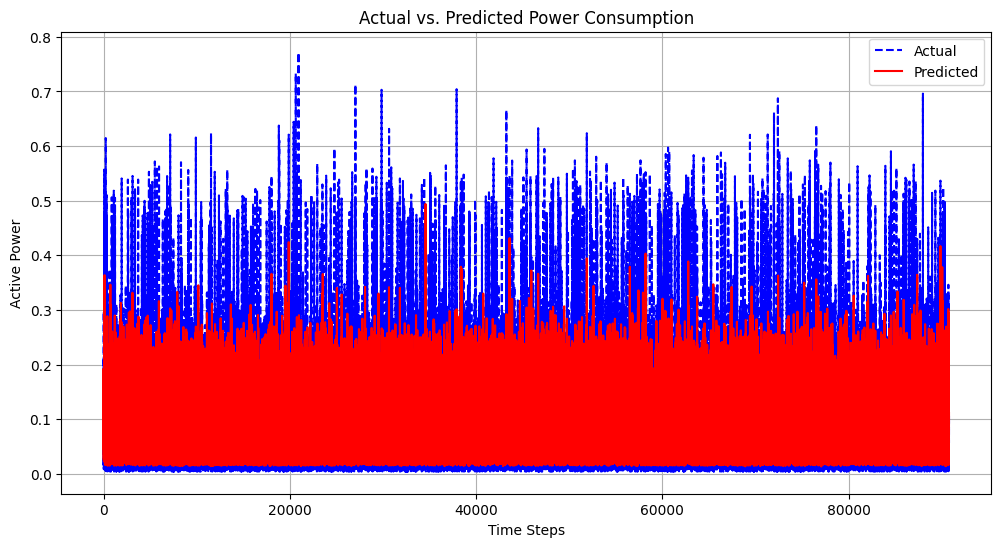

In [18]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Active Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid()
plt.show()

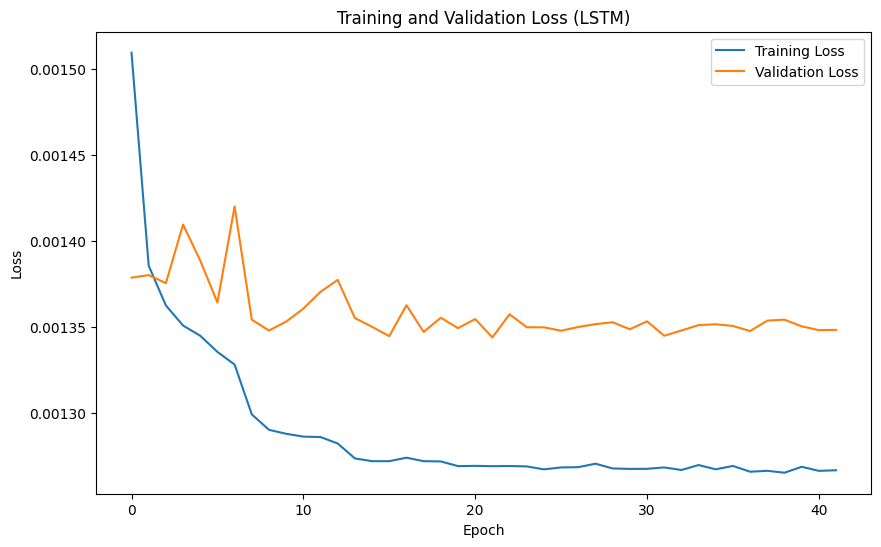

In [19]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.legend()
plt.show()

In [20]:
features_dim = len(FEATURES)

In [ ]:
# LIME Explanation for the LSTM Model

# Flatten the sequential data from 
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Generate feature names for flattened data
feature_names_flat = []
for t in range(time_steps):
    for feature in FEATURES:
        feature_names_flat.append(f"{feature}_t{t+1}")

# Define a wrapper function that reshapes the flat data back to the sequential shape before predicting
def predict_wrapper(flat_data):
    n_samples = flat_data.shape[0]
    reshaped = flat_data.reshape(n_samples, time_steps, features_dim)  # Use features_dim instead of FEATURES
    preds = model_lstm.predict(reshaped)
    return preds.ravel()  # Return a 1D array

# Create a LimeTabularExplainer for regression
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

# Explain the prediction for one test instance (using the first instance as an example)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10  # Adjust to show top contributing features
)

# Display the LIME explanation
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except ImportError:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))

# Alternatively, print the explanation as text in the console
print("LIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")
    
# Save Lime explanation as HTML
lime_html = exp.as_html()   
with open('exp9_lime_explanation.html', 'w') as f:
    f.write(lime_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


LIME Explanation (Feature Contributions):
apparent_power_t7 <= 0.06: -0.0246
current_t7 <= 0.05: -0.0231
active_power_rolling_mean_t7 <= 0.07: -0.0101
active_power_lag_1_t7 <= 0.05: -0.0088
reactive_power_t7 <= 0.05: 0.0064
apparent_power_t6 <= 0.06: -0.0047
year_t5 <= 0.50: -0.0043
current_t6 <= 0.05: -0.0041
year_t6 <= 0.50: 0.0039
year_t1 <= 0.50: 0.0023


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


 10%|█         | 1/10 [00:26<04:01, 26.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 20%|██        | 2/10 [00:47<03:05, 23.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 30%|███       | 3/10 [01:08<02:35, 22.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 40%|████      | 4/10 [01:29<02:10, 21.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 50%|█████     | 5/10 [01:50<01:47, 21.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 60%|██████    | 6/10 [02:10<01:23, 20.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 70%|███████   | 7/10 [02:32<01:03, 21.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 80%|████████  | 8/10 [02:54<00:43, 21.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 90%|█████████ | 9/10 [03:15<00:21, 21.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7319/7319 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


100%|██████████| 10/10 [03:36<00:00, 21.67s/it]


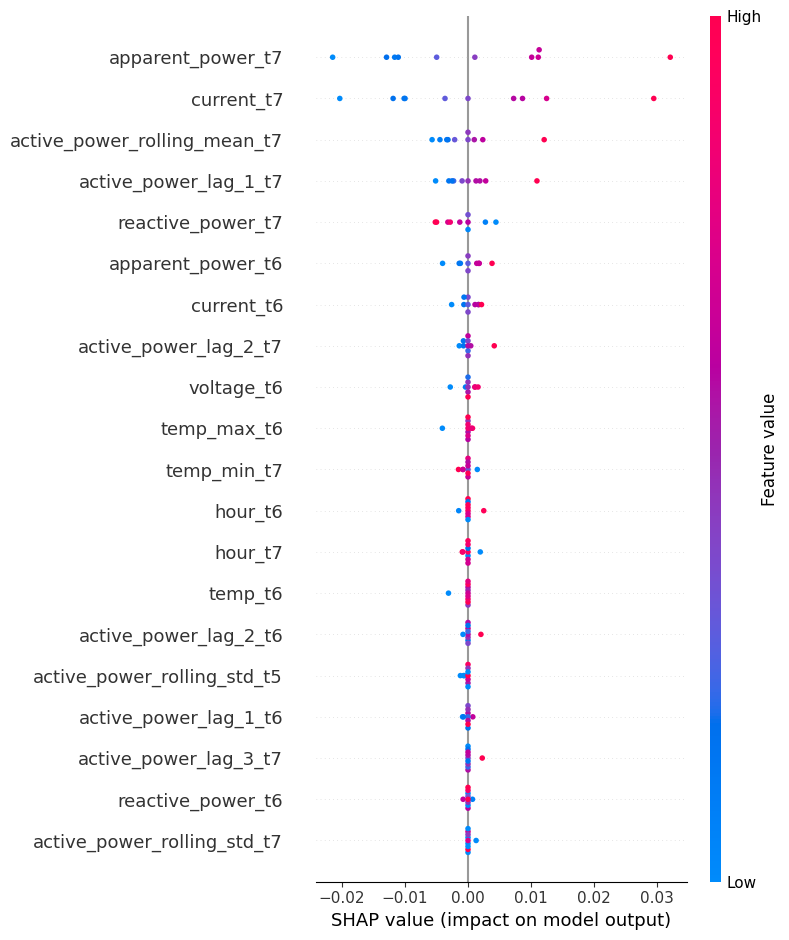

In [22]:
# Define a prediction wrapper
def predict_shap(data):
    # Reshape the flat data back to the original shape (samples, time_steps, features)
    reshaped_data = data.reshape(data.shape[0], time_steps, features_dim)
    return model_lstm.predict(reshaped_data).flatten()

# Use a subset of X_train for the explainer
explainer = shap.KernelExplainer(predict_shap, X_train[:100].reshape(100, -1))  # Flatten for KernelExplainer

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test[:10].reshape(10, -1))  # Flatten for KernelExplainer

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test[:10].reshape(10, -1), feature_names=feature_names_flat)